In [1]:
import pandas as pd
import numpy as np
import random
from scipy.stats import ks_2samp
from datetime import datetime
from datetime import datetime,timedelta
import time
from tqdm import tqdm
from emucast.forecast_emulator import ForecastEmulator
from emucast.utils import nrmse, nmae, eof
from emucast.utils import morph_eof, morph_nmae, morph_nrmse
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px

In [2]:
from importlib.resources import files
import emucast.data

data_path = files(emucast.data) / "load_uk_norm.xlsx"
data = pd.read_excel(data_path, index_col=0)
data = data['demand_MW']*6
data

Timestamp
2019-01-01 00:00:00    2.593886
2019-01-01 00:15:00    2.534934
2019-01-01 00:30:00    2.475983
2019-01-01 00:45:00    2.338428
2019-01-01 01:00:00    2.200873
                         ...   
2019-12-31 22:45:00    2.174672
2019-12-31 23:00:00    2.122271
2019-12-31 23:15:00    2.069869
2019-12-31 23:30:00    2.017467
2019-12-31 23:45:00    2.017467
Name: demand_MW, Length: 35040, dtype: float64

In [3]:
emulator = ForecastEmulator(data, nb_states = 30)

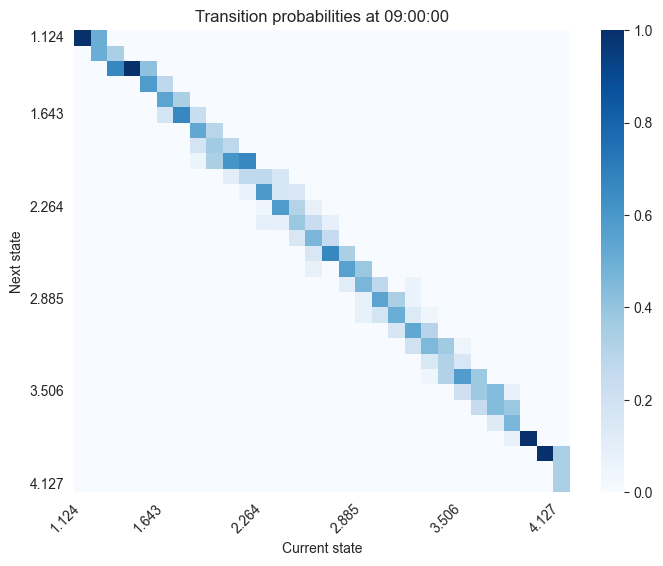

In [4]:
emulator.plot_transition_heatmap(emulator.trans_matrices,
                                 emulator.state_maps,
                                 hour=9, minute =00)

Text(0, 0.5, 'Value')

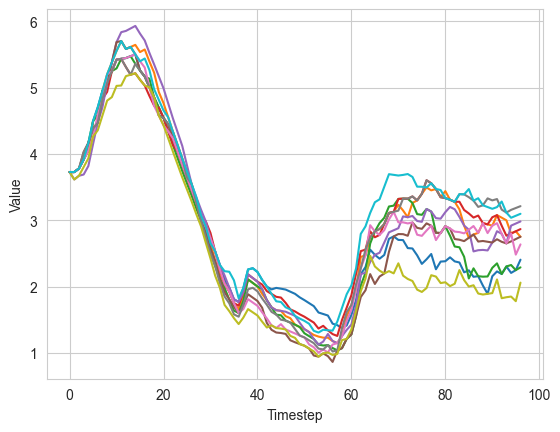

In [5]:
profiles = emulator.generate_profiles(n_profiles = 10,
                                      start_hour = 14,
                                      start_minute = 45,
                                      start_value = 3.68,
                                      n_steps= 97
                                      )
import matplotlib.pyplot as plt
import numpy as np
import plotly.tools as tls

plt.plot(profiles)
plt.xlabel("Timestep")
plt.ylabel("Value")

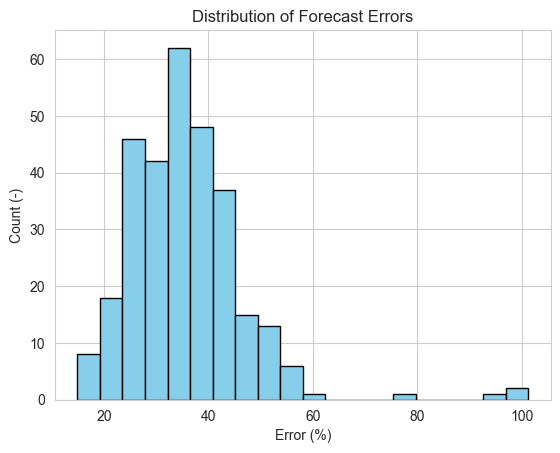

In [6]:
metric_error = 'eof'
profiles,reference,errors = emulator.generate_forecast_profiles(
    reference=None,
    start_time = datetime(2019,1,9,8,0),
    duration_minutes= 60*24,
    n_profiles = 300,
    metric=metric_error
 )

# Plot the distribution of forecast errors
# values along the time horizon for the profiles generated
plt.hist(errors, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Error (%)")
plt.ylabel("Count (-)")
plt.title("Distribution of Forecast Errors")
plt.show()

Target Error (%) = 80.00
Selected Profile Error (%) = 76.56
Tuned Profile Error (%) = 80.00


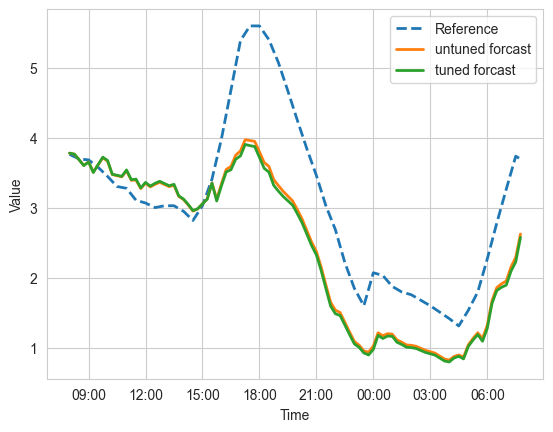

In [12]:
target_error = 80
selected_profile, error_selected_profile = emulator.select_profile(profiles,
                                           errors,
                                           target_error = target_error,
                                           selection = 'closest')

# Tune the profile
from emucast.utils import morph_nrmse, morph_nmae, morph_eof, nrmse, nmae, eof
morph_func = {"nrmse": morph_nrmse,"nmae": morph_nmae, 'eof': morph_eof}[metric_error.lower()]
tuned_profile = morph_func(reference.values,selected_profile.values,target_error)
tuned_profile = pd.Series(tuned_profile,index = reference.index)
metric_func = {"nrmse": nrmse,"nmae": nmae, 'eof': eof}[metric_error.lower()]
error_tuned_profile = metric_func(reference.values,tuned_profile.values)

# Display results
print(f"Target Error (%) = {target_error:.2f}")
print(f"Selected Profile Error (%) = {error_selected_profile:.2f}")
print(f"Tuned Profile Error (%) = {error_tuned_profile:.2f}")
plt.plot(reference.index.to_numpy(), reference.values, label="Reference", linestyle="--", linewidth=2)
plt.plot(reference.index.to_numpy(), selected_profile.values, label='untuned forcast', linewidth=2)
plt.plot(reference.index.to_numpy(),tuned_profile.values, label='tuned forcast', linewidth=2)
plt.xlabel("Time")
plt.ylabel("Value")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.legend()
plt.show()

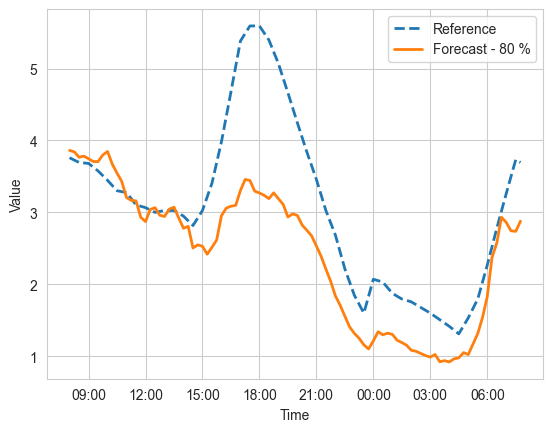

In [13]:
target_error = 80
start_time = datetime(2019,1,9,8,0)

reference, forecast = emulator.forecast( reference=None,
                                        start_time = start_time,
                                        duration_minutes= 60*24,
                                        n_profiles = 300, # optional as already an attribute of the emulator object
                                        metric='eof',
                                        target_error = target_error,
                                        selection = 'closest')

plt.plot(reference.index.to_numpy(), reference.values, label="Reference", linestyle="--", linewidth=2)
plt.plot(forecast.index.to_numpy(), forecast.values, label=f'Forecast - {target_error:.0f} %', linewidth=2)
plt.xlabel("Time")
plt.ylabel("Value")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.legend()
plt.savefig("forecast_chart.svg", format="svg")
plt.show()

<AxesSubplot:>

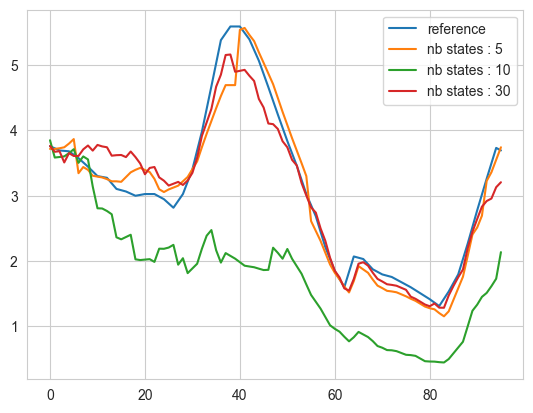

In [14]:
start_time = datetime(2019,1,9,8,0)
n_steps = 96
time_index = [start_time + i*pd.Timedelta(minutes = 15) for i in range(n_steps)]
reference = data.loc[time_index]
df = pd.DataFrame()
df['reference']=reference.values

for nb_states_test in [5, 10, 30] :

    emulator = ForecastEmulator(ts_in = data,
                                nb_states = nb_states_test)

    profile = emulator.generate_profiles(n_profiles = 1,
                                         start_hour = start_time.hour,
                                         start_minute = start_time.minute,
                                         start_value = reference.values[0],
                                         n_steps = 96)

    df[f"nb states : {nb_states_test}"] = profile

df.plot()

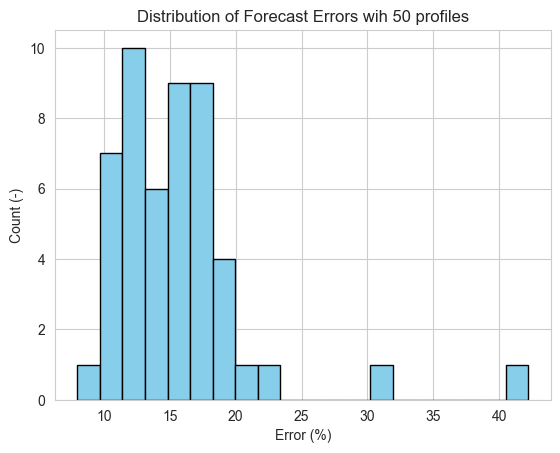

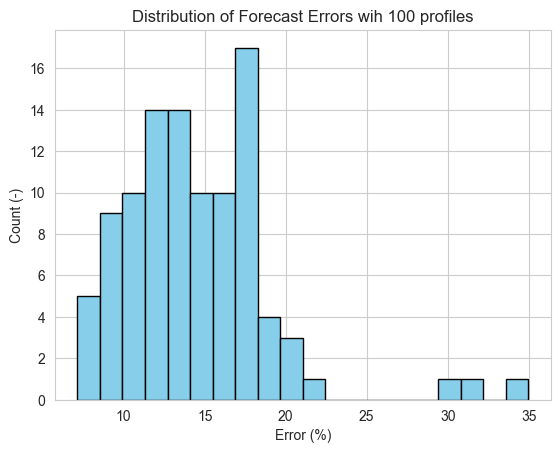

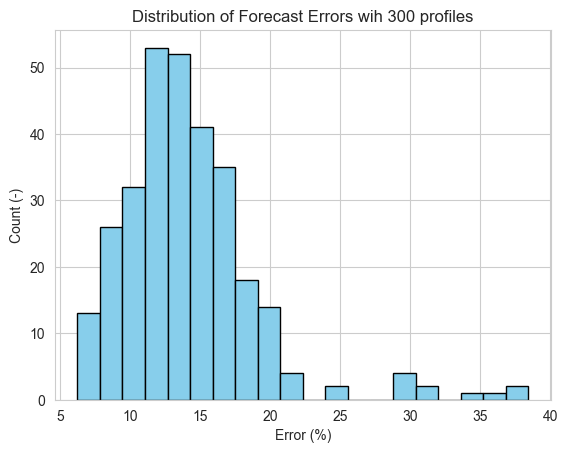

In [15]:
for n_profiles in [50,100,300]:

    metric_error = 'nrmse'
    profiles,reference,errors = emulator.generate_forecast_profiles(
        reference=None,
        start_time = datetime(2019,1,9,8,0),
        duration_minutes= 60*24,
        n_profiles = n_profiles,
        metric=metric_error
     )

    plt.hist(errors, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel("Error (%)")
    plt.ylabel("Count (-)")
    plt.title(f"Distribution of Forecast Errors wih {n_profiles} profiles")
    plt.show()

In [16]:
import time
from tqdm import tqdm
import warnings

results=[]

nb_states_list = [5, 30]
nb_profiles_list = [50, 300]
nb_steps_list = [2, 4, 8, 16, 32, 48, 96, 144, 288]
total = len(nb_states_list)*len(nb_profiles_list)*len(nb_steps_list)


with tqdm(total = total) as pbar:
    for nb_states in  nb_states_list :
        for nb_profiles in  nb_profiles_list:

            emulator = ForecastEmulator(ts_in = data,
                                        nb_states = nb_states,
                                        nb_forecast_profiles=  nb_profiles)

            for nb_steps in nb_steps_list:

                start_t = time.time()

                ref, forecast = emulator.forecast(start_time = datetime(2019,1,1,18,0),
                                                  duration_minutes  = 15*nb_steps, #original data had 15 min time step
                                                  target_error = 10)  #no impact of target error
                duration = time.time() - start_t

                results.append({'nb_states' : nb_states,
                                'nb_profiles' : nb_profiles,
                                'nb_steps' : nb_steps,
                                'cpu_time': duration*1000})

                pbar.update(1)

results=pd.DataFrame(results)

 44%|████▍     | 16/36 [00:06<00:05,  3.39it/s]C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

 92%|█████████▏| 33/36 [00:14<00:01,  2.96it/s]C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

100%|██████████| 36/36 [00:16<00:00,  2.24it/s]


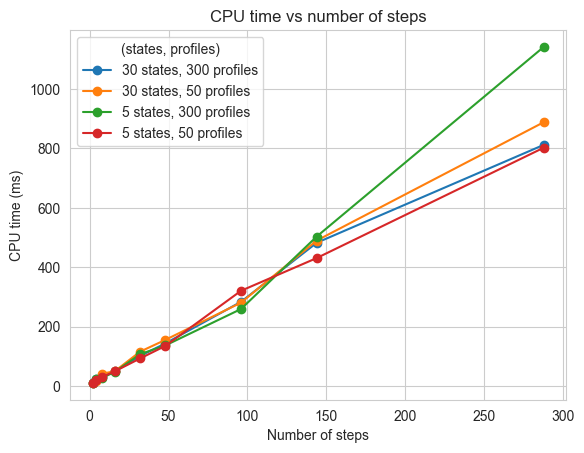

In [17]:
# Create a column for the combination
results["combination"] = results["nb_states"].astype(str) + " states, " + results["nb_profiles"].astype(str) + " profiles"

# Pivot so each combination becomes a column
pivot_df = results.pivot_table(
    index="nb_steps",
    columns="combination",
    values="cpu_time"
)

# Plot
pivot_df.plot(marker="o")
plt.xlabel("Number of steps")
plt.ylabel("CPU time (ms)")
plt.title("CPU time vs number of steps")
plt.legend(title="(states, profiles)")
plt.show()

In [18]:
# Load Profiles
from emucast.data import load_sample_data
emulator = ForecastEmulator(load_sample_data,
                            nb_states = 30,
                            nb_forecast_profiles = 300)

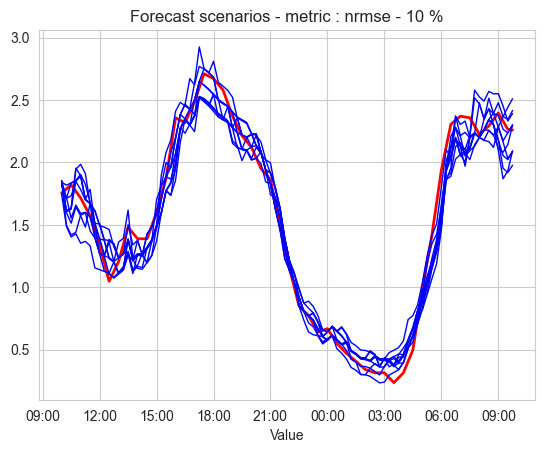

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.



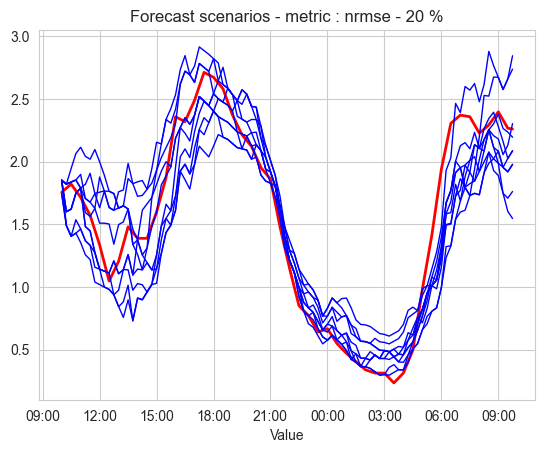

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.



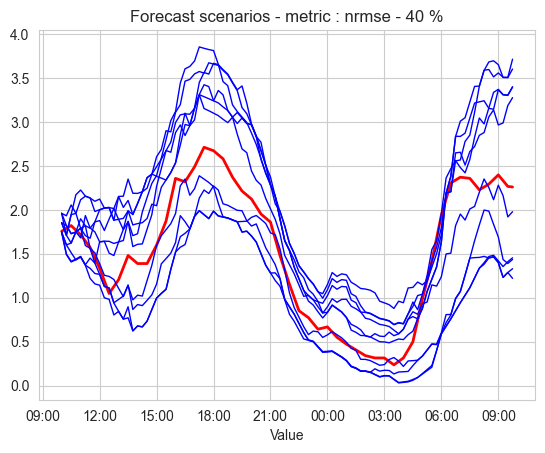

In [21]:
n_runs = 10
error_test = [10, 20, 40 ]
error_metric = 'nrmse'
start_time=datetime(2019,6,25,10,0)
duration_minutes  = 60*24
reference=load_sample_data.loc[start_time:start_time+pd.Timedelta(minutes = duration_minutes)].iloc[:-1]

for target_error in error_test:

    plt.plot(reference.index.to_numpy(), reference.values, label='Ref', color='red', linewidth=2)
    plt.xlabel('Timestep')
    plt.xlabel('Value')
    plt.title(f'Forecast scenarios - metric : {error_metric} - {target_error} %')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    for run in range(n_runs):
        ref, forecast = emulator.forecast(start_time = start_time,
                                                  duration_minutes  = duration_minutes, #original data had 15 min time step
                                                  target_error = target_error)  #no impact of target error

        plt.plot(reference.index.to_numpy(), forecast.values, color='blue', linewidth=1)

    plt.show()

In [22]:
from emucast.data import pv_sample_data
emulator = ForecastEmulator(pv_sample_data,
                            nb_states = 30,
                            nb_forecast_profiles = 300)

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\

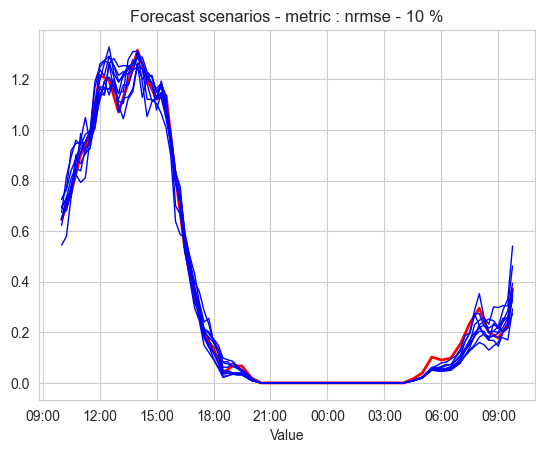

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\

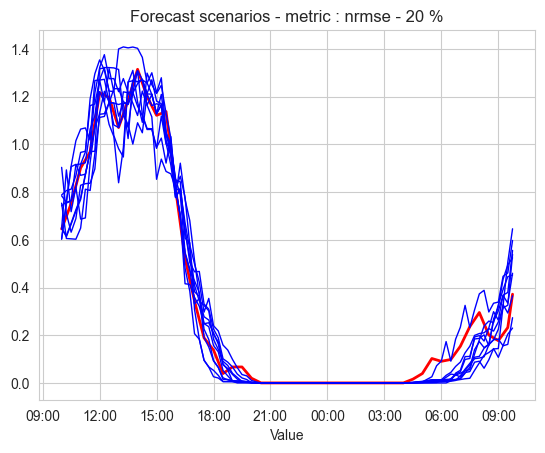

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

C:\_UsersDatas\

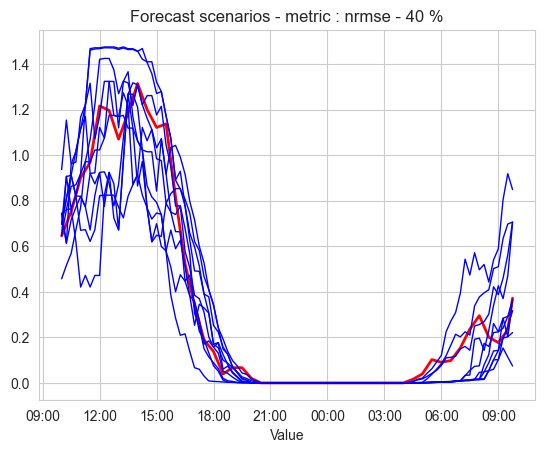

In [23]:
n_runs = 10
error_test = [10, 20, 40 ]
error_metric = 'nrmse'
start_time=datetime(2019,6,25,10,0)
duration_minutes  = 60*24
reference=pv_sample_data.loc[start_time:start_time+pd.Timedelta(minutes = duration_minutes)].iloc[:-1]

for target_error in error_test:

    plt.plot(reference.index.to_numpy(), reference.values, label='Ref', color='red', linewidth=2)
    plt.xlabel('Timestep')
    plt.xlabel('Value')
    plt.title(f'Forecast scenarios - metric : {error_metric} - {target_error} %')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    for run in range(n_runs):
        ref, forecast = emulator.forecast(start_time = start_time,
                                                  duration_minutes  = duration_minutes, #original data had 15 min time step
                                                  target_error = target_error)  #no impact of target error

        plt.plot(reference.index.to_numpy(), forecast.values, color='blue', linewidth=1)

    plt.show()

In [24]:
from emucast.data import price_sample_data
emulator = ForecastEmulator(price_sample_data,
                            nb_states = 60,
                            nb_forecast_profiles = 300)

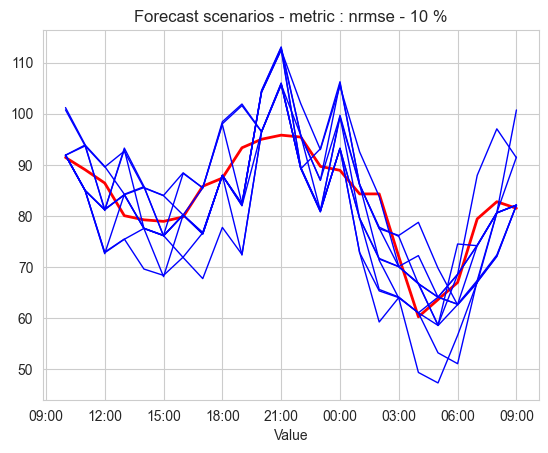

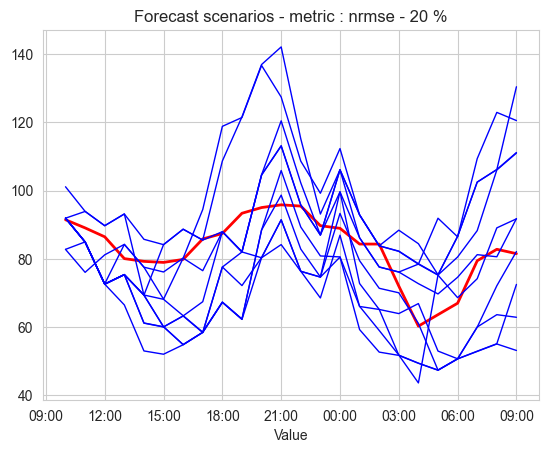

C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.



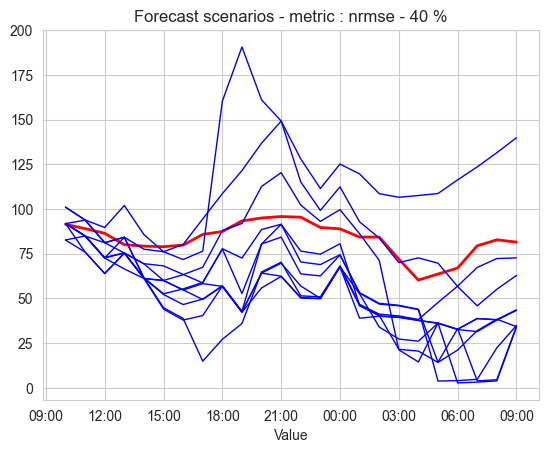

In [25]:
n_runs = 10
error_test = [10, 20, 40 ]
error_metric = 'nrmse'
start_time=datetime(2021,6,25,10,0)
duration_minutes  = 60*24
reference=price_sample_data.loc[start_time:start_time+pd.Timedelta(minutes = duration_minutes)].iloc[:-1]

for target_error in error_test:

    plt.plot(reference.index.to_numpy(), reference.values, label='Ref', color='red', linewidth=2)
    plt.xlabel('Timestep')
    plt.xlabel('Value')
    plt.title(f'Forecast scenarios - metric : {error_metric} - {target_error} %')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    for run in range(n_runs):
        ref, forecast = emulator.forecast(start_time = start_time,
                                                  duration_minutes  = duration_minutes, #original data had 15 min time step
                                                  target_error = target_error)  #no impact of target error

        plt.plot(reference.index.to_numpy(), forecast.values, color='blue', linewidth=1)

    plt.show()

In [26]:
net_load = load_sample_data-pv_sample_data  #same as for the energy management strategy in ems_power_smoothing

# Initialize the forecast emulator
emulator = ForecastEmulator(ts_in = net_load,
                            nb_states = 30,
                            nb_forecast_profiles =300)

In [27]:
import random
from datetime import datetime,timedelta

start_time = datetime(2019,1,1,0,0)
end_time = datetime(2019,7,1,0,0)
error_metric = 'nrmse'
metric_func = {"nrmse": nrmse,"nmae": nmae, 'eof': eof}[error_metric.lower()]

Ndates = 20
error_targets = np.linspace(10,50,5)

# build all possible datetimes at 15min steps
max_start = end_time - timedelta(hours = 24)  # last start time possible
all_times = pd.date_range(start_time,max_start,freq = "15min")
rand_starts = random.sample(list(all_times),Ndates)

horizons = [2,4,8,24]
results = []

total_runs = Ndates * len(error_targets)
run_id = 0

with tqdm(total = total_runs,desc = "Simulations") as pbar:
    for st in rand_starts:
        for et in error_targets:
            run_id += 1

            reference,forecast = emulator.forecast(start_time = st,
                                                   duration_minutes = 60 * 24,
                                                   metric = error_metric,
                                                   target_error = et,
                                                   selection = 'closest'
                                                   )

            row = {'run': run_id,'error_target': et}
            for h in horizons:
                nsteps = int(h) * 4 #15 min time steps
                row[f'error_{h}h'] = metric_func(reference.values[:nsteps],forecast.values[:nsteps])
            results.append(row)

            pbar.update(1)

df = pd.DataFrame(results)

Simulations:   1%|          | 1/100 [00:00<01:02,  1.59it/s]C:\_UsersDatas\zhangzhe\anaconda\envs\DistNetAnlys\lib\site-packages\emucast\forecast_emulator.py:597: UserWarning:

Generated profile out of bounds. Clipped to min/max values from training data.

Simulations: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


<AxesSubplot:>

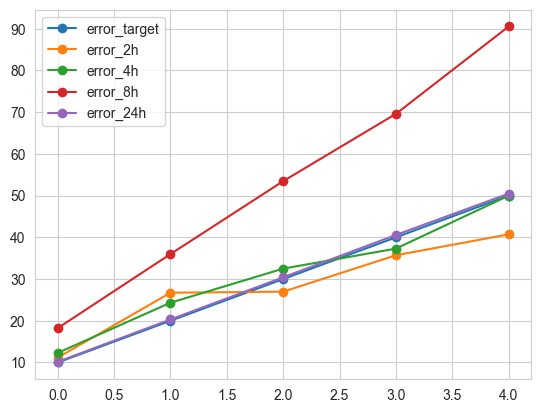

In [28]:
df_mean = df.groupby('error_target').mean(numeric_only = True).reset_index()
df_mean.drop(columns=["run"], inplace=True)
# df_mean.set_index(df_mean.columns[0])
df_mean.plot(marker='o')

In [29]:
emulator = ForecastEmulator(load_sample_data,
                            nb_states = 30,
                            nb_forecast_profiles = 300)

In [30]:
start_time = emulator.ts_in.index[0]
end_time = emulator.ts_in.index[-1]

# setup parameters for the tuning
Ndates = 3
Nruns = 10
n_steps= int(3600*24/emulator.deltaT.total_seconds())

# build all possible datetimes
max_start = end_time - timedelta(hours = 24)  # last start time possible
all_times = pd.date_range(start_time,max_start,freq = "15min")
rand_starts = random.sample(list(all_times),Ndates)

# build reference profile along the random dates
ref_arr = []
for start in rand_starts:
    # Compute timestamps
    timestamps = [start + i * emulator.deltaT for i in range(n_steps)]
    #Extract ref profile
    ref_profile = emulator.ts_in.loc[timestamps].values
    ref_arr=np.concatenate((ref_arr, ref_profile))
# Compute reference deviations
delta_ref = np.diff(ref_arr)

# Investigate different nb_states
nb_states_test =  np.linspace(5,100,20, dtype=int)
p_arr = np.zeros((len(nb_states_test), Nruns))
ks_arr = np.zeros((len(nb_states_test), Nruns))
delta_mean_arr = np.zeros((len(nb_states_test), Nruns))

# Loop along all the tests
total = Ndates*Nruns*len(nb_states_test)
with tqdm(total = total) as pbar:
    for i, nb_states in enumerate(nb_states_test) :
        # Retrain the emulator model for given nb_states
        emulator.nb_states = nb_states
        emulator.state_maps, emulator.state_maps_arr = emulator.set_states(emulator.ts_in, emulator.nb_states)
        ts_disrete = emulator.rediscretize_ts_in(emulator.ts_in, emulator.state_maps)
        emulator.trans_matrices , emulator.trans_matrices_arr = emulator.compute_transition_matrices(ts_disrete, emulator.state_maps)

        for j in range(Nruns):
            # Generate MC model profiles for given run and nb_states
            model_arr = []
            for start in rand_starts:
                model_profile = emulator.generate_profiles(start_hour = start.hour,
                                                           start_minute = start.minute,
                                                           n_steps = n_steps)
                model_arr=np.concatenate((model_arr, model_profile[:,0]))

                pbar.update(1)

            # Compute model deviations for given run and nb_states
            delta_model = np.diff(model_arr)
            # Compute and store stats
            ks_stat, p_value = ks_2samp(delta_ref,  delta_model)
            p_arr[i,j] = p_value
            ks_arr[i,j] = ks_stat
            delta_mean_arr[i,j] = abs(np.mean(abs(delta_ref))-np.mean(abs(delta_model)))

100%|██████████| 600/600 [00:47<00:00, 12.54it/s]


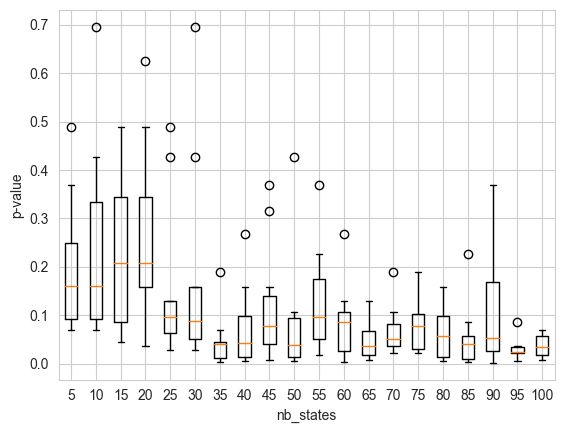

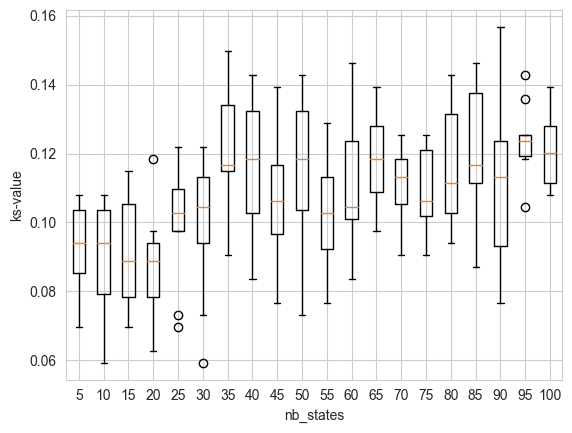

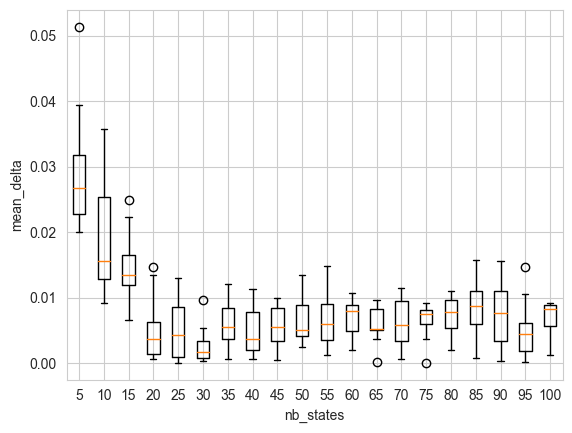

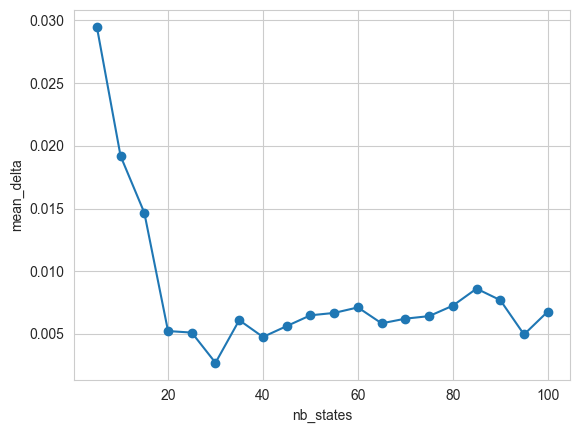

In [32]:
# Calculate mean values along the runs for each parameter
mean_p = np.mean(p_arr, axis=1)
mean_ks = np.mean(ks_arr, axis=1)
mean_delta = np.mean(delta_mean_arr, axis=1)

plt.boxplot(p_arr.T, labels = nb_states_test)
plt.xlabel('nb_states')
plt.ylabel('p-value')
plt.show()
plt.boxplot(ks_arr.T, labels=nb_states_test)
plt.xlabel('nb_states')
plt.ylabel('ks-value')
plt.show()
plt.boxplot(delta_mean_arr.T, labels=nb_states_test)
plt.xlabel('nb_states')
plt.ylabel('mean_delta')
plt.show()
plt.plot(nb_states_test, mean_delta, marker = 'o')
plt.xlabel('nb_states')
plt.ylabel('mean_delta')
plt.show()

In [33]:
# Droite entre premier et dernier point
line = np.linspace(mean_delta[0], mean_delta[-1], len(mean_delta))
# Distance verticale
distances = np.abs(mean_delta - line)
elbow_index = np.argmax(distances)
print(f"Selected value : {nb_states_test[elbow_index]}")
print(f"Assigned value : {emulator.nb_states}")

Selected value : 30
Assigned value : 100


In [34]:
emulator = ForecastEmulator(load_sample_data,
                            nb_states = 30,
                            nb_forecast_profiles = 300)

In [35]:
start_time = emulator.ts_in.index[0]
end_time = emulator.ts_in.index[-1]

# setup parameters for the tuning
Ndates = 3
Nruns = 10
n_steps= int(3600*24/emulator.deltaT.total_seconds())
nb_profiles_test =  np.linspace(50,500,10, dtype=int)

# build all possible datetimes
max_start = end_time - timedelta(hours = 24)  # last start time possible
all_times = pd.date_range(start_time,max_start,freq = "15min")
rand_starts = random.sample(list(all_times),Ndates)

# Generate profile along the random dates
perf_arr = np.zeros((len(nb_profiles_test), Nruns))
total = Ndates*Nruns*len(nb_profiles_test)
with tqdm(total = total) as pbar:
    for i, nb_profiles in enumerate(nb_profiles_test) :
        for start in rand_starts:
            for j in range(Nruns):
                _,_,errors = emulator.generate_forecast_profiles( reference=None,
                                                                   start_time = start,
                                                                   duration_minutes= 60*24,
                                                                   n_profiles = nb_profiles
                                                                  )
                # Define bins
                bins = np.linspace(0, 1, 101)  # 100 bins
                filled_bins = len(np.unique(np.digitize(errors, bins) - 1))  # Subtract 1 to convert to 0-based index
                value_range = np.max(errors) - np.min(errors)
                perf_arr[i,j] = filled_bins + value_range

                pbar.update(1)

100%|██████████| 300/300 [01:17<00:00,  3.86it/s]


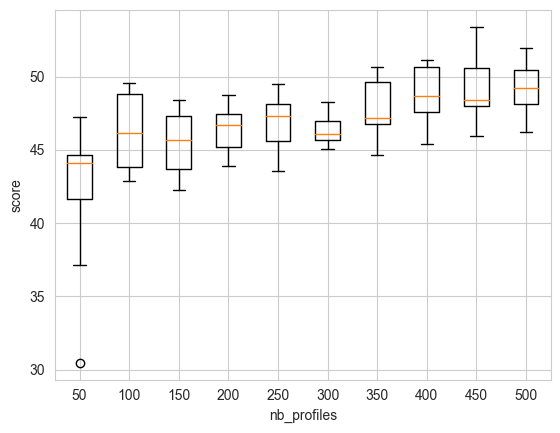

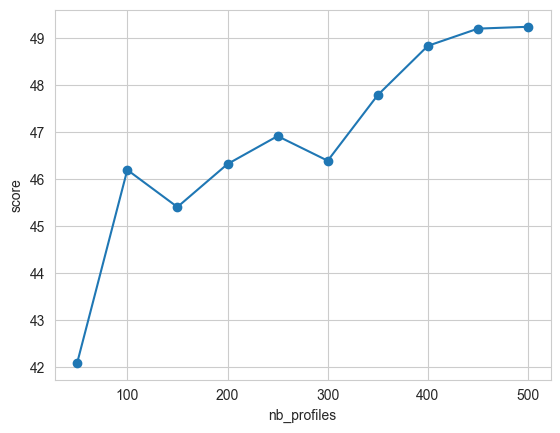

In [36]:
plt.boxplot(perf_arr.T, labels=nb_profiles_test)
plt.xlabel('nb_profiles')
plt.ylabel('score')
plt.show()
plt.plot(nb_profiles_test, np.mean(perf_arr, axis = 1), marker = 'o')
plt.xlabel('nb_profiles')
plt.ylabel('score')
plt.show()

Text(0, 0.5, 'Count (-)')

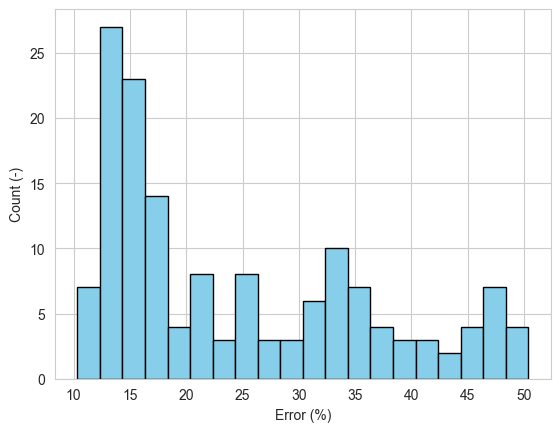

In [37]:
_,_,errors = emulator.generate_forecast_profiles( reference=None,
                                                  start_time = start,
                                                 duration_minutes= 60*24,
                                                  n_profiles = 150
                                                                  )
plt.hist(errors, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Error (%)")
plt.ylabel("Count (-)")

In [38]:
# Droite entre premier et dernier point
mean_perf = np.mean(perf_arr, axis = 1)
line = np.linspace(mean_perf[0], mean_perf[-1], len(mean_perf))
# Distance verticale
distances = np.abs(mean_perf - line)
elbow_index = np.argmax(distances)
print(f"Selected value : {nb_profiles_test[elbow_index]}")

Selected value : 100


-------------------------------
Tune "nb_states" parameters ...


100%|██████████| 600/600 [00:35<00:00, 16.71it/s]

Selected value : 15


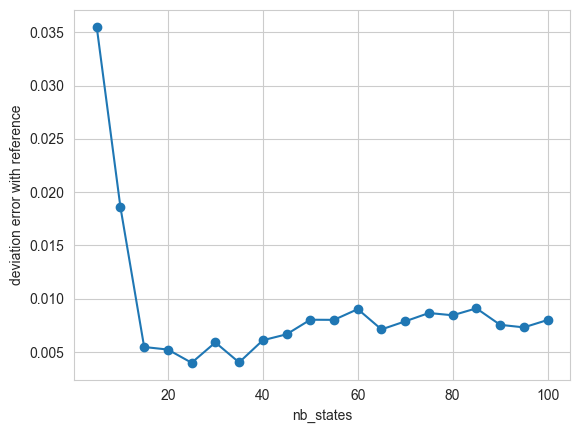

-------------------------------
Tune "nb_forecast_profiles" parameter ...


100%|██████████| 300/300 [01:25<00:00,  3.51it/s]

Selected value : 450


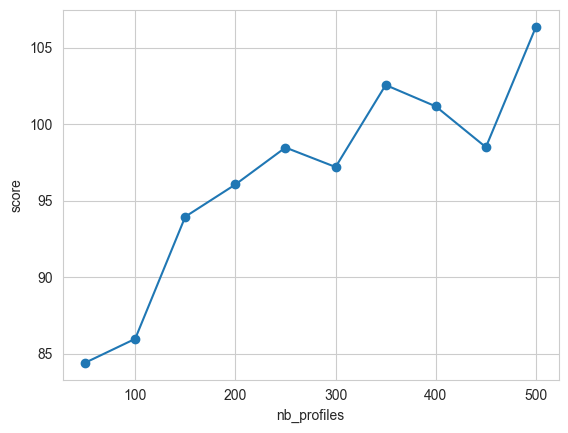

In [39]:
emulator.parameters_tuning()